In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

# MNIST CNN

## Data import

In [3]:
#path = untar_data(URLs.MNIST); path

PosixPath('/home/jupyter/.fastai/data/mnist_png')

In [7]:
path = Path('/home/jupyter/.fastai/data/mnist_png')

In [8]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/mnist_png/testing'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training')]

In [10]:
il = ImageList.from_folder(path, convert_mode='L')

In [12]:
defaults.cmap = 'binary'

In [13]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/jupyter/.fastai/data/mnist_png

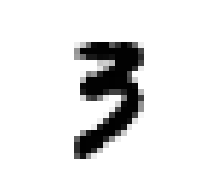

In [25]:
il[0].show()

In [16]:
sd = il.split_by_folder(train='training', valid='testing')

In [17]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/jupyter/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/jupyter/.fastai/data/mnist_png;

Test: None

In [20]:
(path/'training').ls()

[PosixPath('/home/jupyter/.fastai/data/mnist_png/training/3'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/1'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/7'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/8'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/0'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/6'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/9'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/2'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/4'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/5')]

In [21]:
ll = sd.label_from_folder()

In [22]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
3,3,3,3,3
Path: /home/jupyter/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
3,3,3,3,3
Path: /home/jupyter/.fastai/data/mnist_png;

Test: None

In [23]:
x,y = ll.train[0]

3 torch.Size([1, 28, 28])


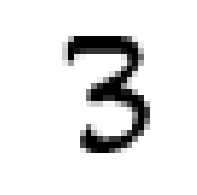

In [24]:
x.show()
print(y, x.shape)

In [30]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [31]:
ll = ll.transform(tfms)

In [33]:
bs = 128

In [34]:
# We are not using imagenet_stats because we are not using pretrained model

data = ll.databunch(bs=bs).normalize()

In [35]:
data

ImageDataBunch;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
3,3,3,3,3
Path: /home/jupyter/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
3,3,3,3,3
Path: /home/jupyter/.fastai/data/mnist_png;

Test: None

In [36]:
x,y = data.train_ds[0]

Label: 3


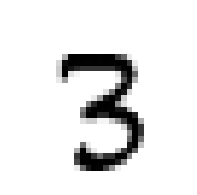

In [37]:
x.show()
print('Label:', y)

In [38]:
def _plot(i, j, ax): data.train_ds[0][0].show(ax, cmap='gray')

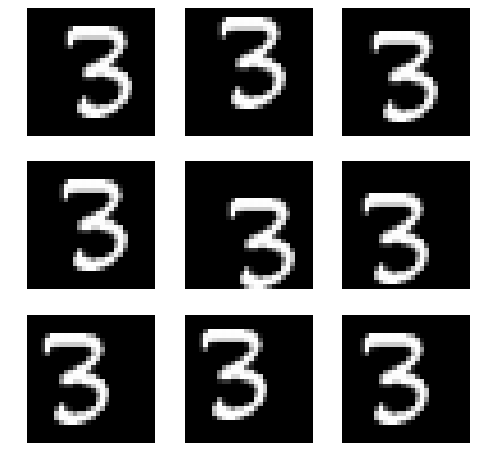

In [43]:
plot_multi(_plot, 3, 3, figsize=(8,8))

In [45]:
xb, yb = data.one_batch()
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

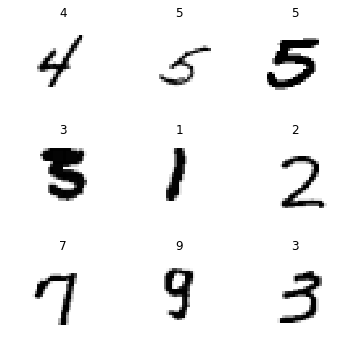

In [46]:
data.show_batch(rows=3, figsize=(5,5))

## Basic CNN with batchnorm

In [47]:
def conv(ni, nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [55]:
model = nn.Sequential(
    conv(1,8),   #new_size = 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8,16),  #new_size = 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16,32), #new_size = 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32,16), #new_size = 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16,10), #new_size = 1
    nn.BatchNorm2d(10),
    Flatten()    #remove the (1,1) grid
    )

In [56]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics = accuracy)

In [57]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [58]:
xb = xb.cuda()

In [59]:
model(xb).shape

torch.Size([128, 10])

In [61]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


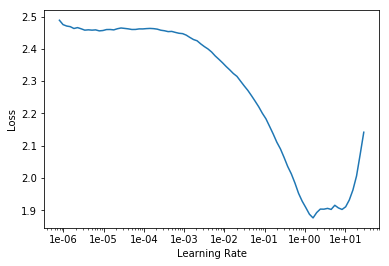

In [62]:
learn.recorder.plot()

In [63]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.226170,0.652664,0.795000,00:26
1,0.139587,0.067542,0.977800,00:26
2,0.076451,0.042145,0.985900,00:26


## Refactor

In [64]:
def conv2(ni, nf): return conv_layer(ni, nf, stride=2) # conv_layer include Batchnorm and ReLu

In [65]:
model = nn.Sequential(
    conv2(1,8), #14
    conv2(8,16), #7
    conv2(16,32),#4
    conv2(32,16),#2
    conv2(16,10),#1
    Flatten()    #remove (1,1) grid
    )

In [66]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics= accuracy)

In [67]:
learn.fit_one_cycle(5, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.257115,0.144454,0.956700,00:26
1,0.166059,0.135771,0.958600,00:26
2,0.129679,0.120504,0.963900,00:26
3,0.085369,0.057207,0.981400,00:27
4,0.067370,0.035091,0.988600,00:26


## Restnet-style

In [68]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf) # Stride 1 conv
        self.conv2 = conv_layer(nf,nf)
    def forward(self,x):
        return x + self.conv2(self.conv1(x))

In [71]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense: bool = False, norm_type: Union[fastai.layers.NormType, NoneType] = <NormType.Batch: 1>, bottle: bool = False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [72]:
model = nn.Sequential(
    conv2(1,8), #14
    res_block(8),
    conv2(8,16), #7
    res_block(16),
    conv2(16,32),#4
    res_block(32),
    conv2(32,16),#2
    res_block(16),
    conv2(16,10),#1
    Flatten()    #remove (1,1) grid
    )

In [73]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni,nf), res_block(nf))

In [74]:
model = nn.Sequential(
    conv_and_res(1,8),   #14
    conv_and_res(8,16),  #7
    conv_and_res(16,32), #4
    conv_and_res(32,16), #2
    conv2(16,10),        #1
    Flatten()
    
    )

In [76]:
learn = Learner(data, model, loss_func= nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


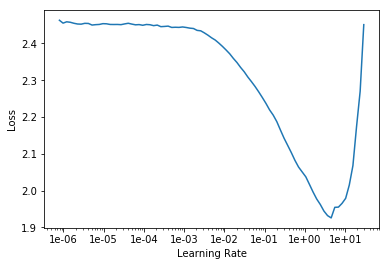

In [77]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [78]:
learn.fit_one_cycle(5, max_lr=.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.190879,0.264707,0.915000,00:30
1,0.107652,0.106279,0.967100,00:28
2,0.075449,0.086745,0.972600,00:28
3,0.046582,0.027418,0.992200,00:28
4,0.025899,0.018260,0.994300,00:29


In [79]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________